In [1]:
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   

import matplotlib.pylab as plt
%matplotlib inline

In [10]:
#Import all train data those are concated together and the Labels.
df = pd.read_csv("D:/Project/Sample data/label_10molding_machine_5000dp_pro.csv", index_col=0,)
columns = df.drop(["Class"], axis=1).columns

In [11]:
df

,Date,cycle,Ob0,Ob1,Ob2,Ob3,Ob4,Ob5,Ob6,Ob7,...,Ob108,Ob109,Ob110,Ob111,Ob112,Ob113,Ob114,Ob115,Ob116,Class
Machine,,,,,,,,,,,,,,,,,,,,,
0,20170101,13,9433.11,4415.22,770.79,3276,450.31,176.77,0.00,9.46,...,17.48,80.46,28.76,91.20,43.14,7.66,78.09,63.70,81.88,1
1,20170101,4,61819.89,2311.74,1092.92,24,13.86,162.66,0.00,17.25,...,33.38,79.15,15.95,70.59,84.92,27.41,38.90,38.95,70.78,1
2,20170101,11,56504.60,4604.91,1322.90,3276,24.38,29.18,-0.01,15.68,...,20.22,80.45,77.86,53.19,29.07,84.99,73.33,71.98,80.22,1
3,20170101,8,10708.69,614.75,1115.14,48,450.54,136.37,0.00,10.54,...,29.39,81.40,27.43,5.36,38.63,9.99,69.28,68.94,93.08,1
4,20170101,24,65211.03,3729.76,1004.32,48,450.24,85.42,0.00,9.01,...,27.03,81.25,34.69,0.65,93.27,71.14,52.27,95.43,8.41,1
5,20170101,14,70288.23,2065.84,961.51,3276,29.83,268.57,-0.01,17.62,...,34.39,78.93,73.25,19.18,70.63,73.69,42.60,77.77,53.73,1
6,20170101,11,66022.81,3958.54,1104.15,3276,488.00,23.92,-0.01,12.06,...,20.57,81.30,25.96,41.46,59.61,17.83,13.66,92.44,91.27,1
7,20170101,25,25257.56,4990.56,1187.86,3276,450.74,1.02,-0.01,16.98,...,31.51,80.28,95.36,94.18,48.52,35.92,93.86,56.45,68.77,1
8,20170101,14,62628.86,4517.88,744.53,24,27.31,34.76,0.00,19.90,...,33.87,77.29,83.47,63.73,94.03,9.48,66.85,38.46,36.53,1


In [12]:
def modelfit(alg, X_all, y_all,i, useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_all, label=y_all)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=1)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_all, y_all, eval_metric=['auc'])
    
    print(alg)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_all)
    dtrain_predprob = alg.predict_proba(X_all)[:,1]
    
    sorted_idx = np.argsort(alg.feature_importances_)[::-1]
    f_name = []
    score = []
    print('Important Features:')
    for index in sorted_idx:
        #print([columns[index], alg.feature_importances_[index]])
        f_name.append(columns[index])
        score.append(alg.feature_importances_[index])
    im_Feature= pd.DataFrame(f_name, columns =["f_name"])
    im_Feature["score"] = score
    im_Feature=im_Feature.head(30)
    out_file = "D:/input output csv_10" + "/data_{}.csv".format(i+1)

    im_Feature.to_csv(out_file)
    print(im_Feature.head())
    #Print model report:
    print("\nModel Report")
    #print "Accuracy : %.4g" % metrics.accuracy_score(y_all, X_all)
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_all, dtrain_predprob))

   # print(alg.booster())   
    out_file = "D:/input output csv_10" + "/data_{}.png".format(i+1)

   # print(alg.booster())                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)[:25]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    plt.savefig(out_file)
    print(feat_imp.to_string())

C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-auc:0.995592+0.000428435	test-auc:0.995391+0.000916394
[1]	train-auc:0.998965+8.7742e-05	test-auc:0.9988+0.000171591
[2]	train-auc:0.99928+0.00011417	test-auc:0.999116+0.000222148
[3]	train-auc:0.999573+3.37441e-05	test-auc:0.999457+8.21557e-05
[4]	train-auc:0.999581+2.91319e-05	test-auc:0.99947+8.61278e-05
[5]	train-auc:0.999597+2.31709e-05	test-auc:0.999494+6.63677e-05
[6]	train-auc:0.999599+2.11187e-05	test-auc:0.9995+6.91713e-05
[7]	train-auc:0.999601+2.00499e-05	test-auc:0.999542+3.59753e-05
[8]	train-auc:0.999612+2.68825e-05	test-auc:0.999558+3.28261e-05
[9]	train-auc:0.999652+2.99592e-05	test-auc:0.999585+6.87362e-05
[10]	train-auc:0.999689+4.51097e-05	test-auc:0.999613+8.18712e-05
[11]	train-auc:0.999772+1.18977e-05	test-auc:0.999695+2.59015e-05
[12]	train-auc:0.99989+2.21058e-05	test-auc:0.999817+1.35974e-05
[13]	train-auc:0.999937+2.06774e-05	test-auc:0.999884+1.18977e-05
[14]	train-auc:0.999948+1.29185e-05	test-auc:0.999897+4.98888e-06
[15]	train-auc:0.999961+5.557

C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-auc:0.995592+0.000428435	test-auc:0.995391+0.000916394
[1]	train-auc:0.998965+8.7742e-05	test-auc:0.9988+0.000171591
[2]	train-auc:0.99928+0.00011417	test-auc:0.999116+0.000222148
[3]	train-auc:0.999573+3.37441e-05	test-auc:0.999457+8.21557e-05
[4]	train-auc:0.999581+2.91319e-05	test-auc:0.99947+8.61278e-05
[5]	train-auc:0.999597+2.31709e-05	test-auc:0.999494+6.63677e-05
[6]	train-auc:0.999599+2.11187e-05	test-auc:0.9995+6.91713e-05
[7]	train-auc:0.999601+2.00499e-05	test-auc:0.999542+3.59753e-05
[8]	train-auc:0.999612+2.68825e-05	test-auc:0.999558+3.28261e-05
[9]	train-auc:0.999652+2.99592e-05	test-auc:0.999585+6.87362e-05
[10]	train-auc:0.999689+4.51097e-05	test-auc:0.999613+8.18712e-05
[11]	train-auc:0.999772+1.18977e-05	test-auc:0.999695+2.59015e-05
[12]	train-auc:0.99989+2.21058e-05	test-auc:0.999817+1.35974e-05
[13]	train-auc:0.999937+2.06774e-05	test-auc:0.999884+1.18977e-05
[14]	train-auc:0.999948+1.29185e-05	test-auc:0.999897+4.98888e-06
[15]	train-auc:0.999961+5.557

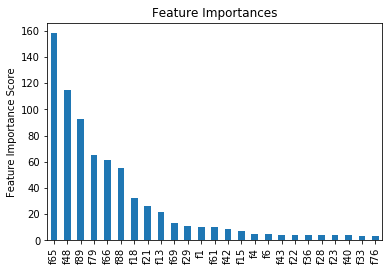

In [13]:
for i in np.arange(2):
   
    y_all = df['Class']
    X_all = df.iloc[:,:-1].values

    xgb1 = XGBClassifier(learning_rate=0.05,
                     base_score=0.0056,
                     n_estimators=50,
                     max_depth=7,
                     min_child_weight=1,
                     gamma=0.1,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective='binary:logistic',
                     nthread=4,
                     scale_pos_weight=3,
                     seed=1)
    modelfit(xgb1, X_all, y_all, i)
    

In [335]:
# Replce NAN with "MeanValue"
#X_all=X_all.fillna(X_all.mean())

In [ ]:
#Check number of noraml and anomaly in the test data after sampling

unique, counts = np.unique(y_all, return_counts=True)
dict(zip(unique, counts))

In [ ]:
#Return true if there is null values
print(np.any(np.isnan(X_all)))

In [ ]:
X_all.head()